<a href="https://colab.research.google.com/github/MussieBirhane/Structural-Element-Identification/blob/main/Corrosion/CNN_Corrosion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This CNN model predict the corrosion of a structural steel image

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
## Define CNN model
# Deep Convolutional Neural Network
# Define ImageClassificationBase class which contains helper methods for training & validation

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                                        # Generate predictions
        loss = F.cross_entropy(out, labels)                       # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                                        # Generate predictions
        loss = F.cross_entropy(out, labels)                       # Calculate loss
        acc = accuracy(out, labels)                               # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()             # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()                # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Use nn.Sequential to chain the layers and activation functions into a single network architecture

class CorrosionModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))

    def forward(self, xb):
        return self.network(xb)
        

In [ ]:
## To seamlessly use a GPU, if one is available

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
## Analyse the dataset
# Look into the extracted folder
data_dir = '/content/drive/MyDrive/CNN_Practice/CNN_task'
print(os.listdir(data_dir))                                 # ['train', 'test']

# Transform the training imagefolder to a pytorch tensor
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

#dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
dataset = ImageFolder(data_dir+'/train', transform = Compose([Resize([32, 32]), ToTensor()]))

# Display the shape and label of the data
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
img, label = dataset[0]
print('shape of dataset[0]:', img.shape)                      # ([3, 32, 32])

# Dataset classes
print(dataset.classes)                                  # ['Corroded', 'Not_corroded']
  

['test', 'train']
shape of dataset[0]: torch.Size([3, 32, 32]) label: 0
['Corroded', 'Not_corroded']


Label:  Corroded (0)


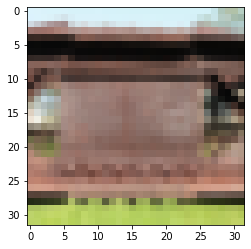

In [ ]:
# Show the dataset
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))                    # permute for imshow to display the image

# The * sign unpack the tuple.dataset[0] instead of tuple (image, label)
show_image(*dataset[10])

In [ ]:
# Training set: to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
# Validation set: to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
# Test set: to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In [ ]:
## Set aside 45 validation set from the training dataset
# To ensure that we always create the same validation set, we'll also set a seed for the random number generator
random_seed = 42
torch.manual_seed(random_seed)
val_size = 45
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

print('training dataset:', len(train_ds))
print('validation dataset:', len(val_ds))

# Load the data in batches
from torch.utils.data.dataloader import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
print('Dataset loaded.')


training dataset: 78
validation dataset: 45
Dataset loaded.


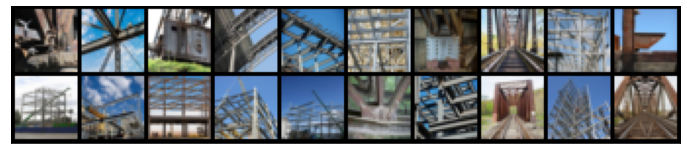

In [ ]:
# Look at batches of images from the dataset using the make_grid method from torchvision

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

# Look at batches of images from the dataset using the make_grid method from torchvision
show_batch(train_dl)

In [ ]:
## Train the model
print('proceeding to the CNN model.....')
model = CorrosionModel()
model

print('check if GPU is available.....')
device = get_default_device()
print('available device:', device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

# Train Model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(CorrosionModel(), device)
evaluate(model, val_dl)

# hyperparmeters (learning rate, no. of epochs, batch_size etc.) to train our model
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


proceeding to the CNN model.....
check if GPU is available.....
available device: cpu
Epoch [0], train_loss: 0.7217, val_loss: 0.6836, val_acc: 0.5875
Epoch [1], train_loss: 0.6785, val_loss: 0.6861, val_acc: 0.5875
Epoch [2], train_loss: 0.6771, val_loss: 0.6791, val_acc: 0.5875
Epoch [3], train_loss: 0.6459, val_loss: 0.6137, val_acc: 0.5875
Epoch [4], train_loss: 0.4990, val_loss: 0.5452, val_acc: 0.5875
Epoch [5], train_loss: 0.4611, val_loss: 0.5128, val_acc: 0.5875
Epoch [6], train_loss: 0.4047, val_loss: 0.4302, val_acc: 0.5875
Epoch [7], train_loss: 0.3909, val_loss: 0.5228, val_acc: 0.8125
Epoch [8], train_loss: 0.3618, val_loss: 0.2023, val_acc: 0.9625
Epoch [9], train_loss: 0.2250, val_loss: 0.1065, val_acc: 0.9625


In [ ]:
# save hyperparameters

hyperparameters = {'num_epochs':num_epochs, 
                   'lr':lr, 'model':model, 
                   'train_dl':train_dl, 
                   'val_dl':val_dl, 
                   'opt_func':opt_func}
                  
%store hyperparameters

#%store -r hyperparameters 

Stored 'hyperparameters' (dict)


plotting the accuracies trend.....


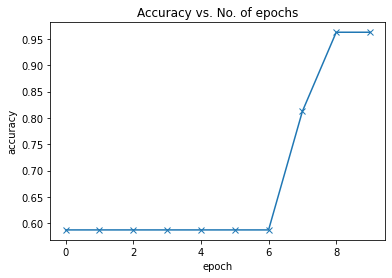

In [ ]:
# plot the validation set accuracies

def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

print('plotting the accuracies trend.....')
plot_accuracies(history)

# We can increase the accuracy of the model adding more convolutional layers to our model, or incrasing the no. of channels 
# in each convolutional layer, or by using regularization techniques.


plotting the losses graph.....


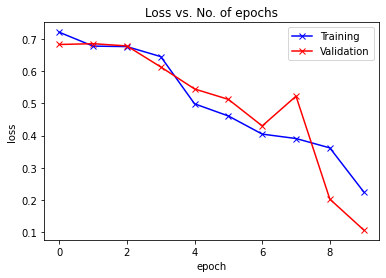

In [ ]:
# plot the losses function

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

# more powerful model is suggested to get more efficiency
# plot the training and validation losses to study the trend

print('plotting the losses graph.....')
plot_losses(history)

Label: Not_corroded , Predicted: Not_corroded


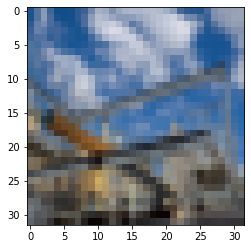

In [ ]:
## Test model for single test image

test_dataset = ImageFolder(data_dir + '/test', transform = Compose([Resize([32, 32]), ToTensor()]))

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

img, label = test_dataset[22]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
# Overall loss and accuracy on test dataset

test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size * 2), device)
result = evaluate(model, test_loader)
result

# the weights and bias of the model can be saved and used on another model using .state_dict method.

{'val_acc': 0.9666666388511658, 'val_loss': 0.10139412432909012}

In [ ]:
# saving the validation loss and accuracy

test_parameters = {'test_loss':result['val_loss'], 
                   'test_acc':result['val_acc']}

%store test_parameters

Stored 'test_parameters' (dict)


In [ ]:
# saving the model weight to avoid training from scratch

torch.save(model.state_dict(), 'CNN_Corrosion.pth')

In [ ]:
# reloading the model for example

model2 = to_device(CorrosionModel(), device)
model2.load_state_dict(torch.load('CNN_Corrosion.pth')) 

<All keys matched successfully>